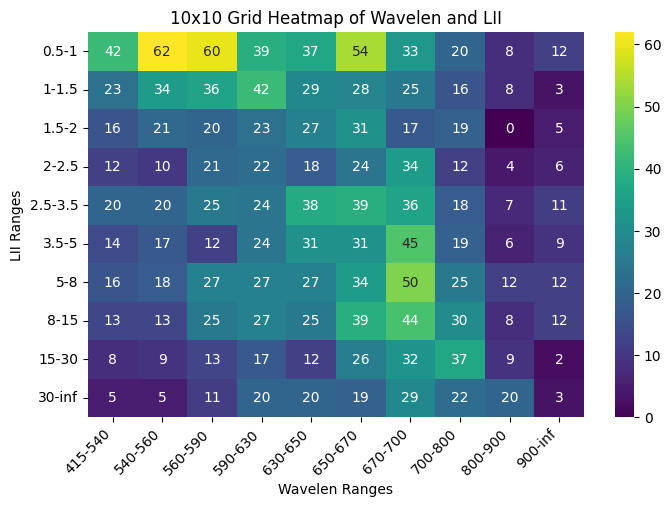

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the ranges for stratification
wavelen_ranges = [(415, 540), (540, 560), (560, 590), (590, 630), (630, 650), (650, 670), (670, 700), (700, 800), (800, 900), (900, np.inf)]
lii_ranges = [(0.5, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, 3.5), (3.5, 5), (5, 8), (8, 15), (15, 30), (30, np.inf)]

# Function to assign grid indices based on the ranges
def get_grid_index(wavelen, lii):
    wavelen_index = next((i for i, (low, high) in enumerate(wavelen_ranges) if low < wavelen <= high), None)
    lii_index = next((i for i, (low, high) in enumerate(lii_ranges) if low < lii <= high), None)
    return wavelen_index, lii_index

# Read the CSV file
datafile = 'cleandata1.csv'  # Replace with your file path
df = pd.read_csv(datafile)

# Create an empty 10x10 grid for counting occurrences
grid = np.zeros((10, 10))

# Iterate over the data and fill the grid
for _, row in df.iterrows():
    wavelen, lii = row['Wavelen'], row['LII']
    wavelen_index, lii_index = get_grid_index(wavelen, lii)
    if wavelen_index is not None and lii_index is not None:
        grid[lii_index, wavelen_index] += 1
    else:
        print(f"Value out of range: Wavelen={wavelen}, LII={lii}")

# Create a heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(grid, annot=True, fmt=".0f", cmap="viridis")
plt.title('10x10 Grid Heatmap of Wavelen and LII')
plt.xlabel('Wavelen Ranges')
plt.ylabel('LII Ranges')
plt.xticks(ticks=np.arange(10)+0.5, labels=[f'{low}-{high}' for low, high in wavelen_ranges], rotation=45, ha='right')
plt.yticks(ticks=np.arange(10)+0.5, labels=[f'{low}-{high}' for low, high in lii_ranges], rotation=0)
plt.show()


In [5]:
df.describe()

,Wavelen,LII
count,2202.000000,2202.000000
mean,647.589289,9.856441
std,93.246959,24.819044
min,415.362329,0.503462
25%,581.029536,1.330673
50%,646.153320,3.034525
75%,681.356262,8.054088
max,1198.939516,408.481842


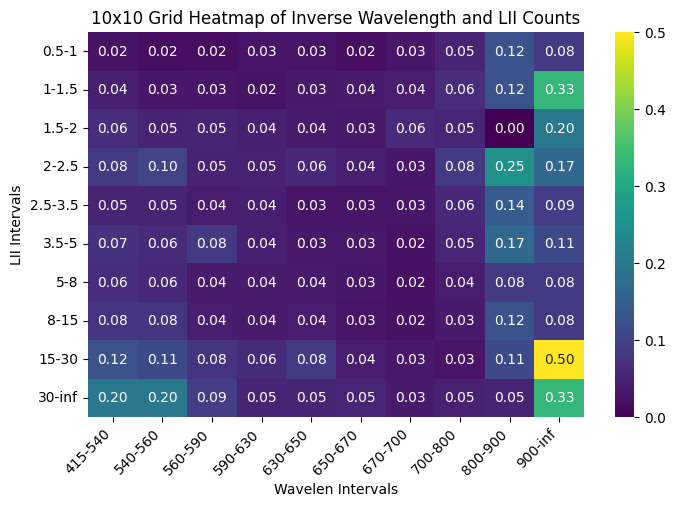

In [2]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read the CSV file
datafile = 'cleandata1.csv'  # Replace with your file path
df = pd.read_csv(datafile)

# Extract Wavelen and LII
wavelen = df['Wavelen']
lii = df['LII']

# Define the specified bin ranges for Wavelen and LII
wavelen_ranges = [(415, 540), (540, 560), (560, 590), (590, 630), (630, 650), (650, 670), (670, 700), (700, 800), (800, 900), (900, np.inf)]
lii_ranges = [(0.5, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, 3.5), (3.5, 5), (5, 8), (8, 15), (15, 30), (30, np.inf)]

# Function to assign grid indices based on the ranges
def get_grid_index(value, ranges):
    for i, (low, high) in enumerate(ranges):
        if low < value <= high:
            return i
    return None

# Create a 10x10 grid for counting occurrences
grid = np.zeros((10, 10))

# Fill the grid with counts
for w, l in zip(wavelen, lii):
    w_index = get_grid_index(w, wavelen_ranges)
    l_index = get_grid_index(l, lii_ranges)
    if w_index is not None and l_index is not None:
        grid[l_index, w_index] += 1

# Compute the inverse of the counts
inverse_grid = np.zeros_like(grid)
with np.errstate(divide='ignore'):  # Ignore division by zero warnings
    inverse_grid = np.where(grid != 0, 1.0 / grid, 0)

# Create the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(inverse_grid, annot=True, fmt=".2f", cmap="viridis")
plt.title('10x10 Grid Heatmap of Inverse Wavelength and LII Counts')
plt.xlabel('Wavelen Intervals')
plt.ylabel('LII Intervals')

# Setting the ticks to show bin ranges
plt.xticks(ticks=np.arange(10) + 0.5, labels=[f'{low}-{high}' for low, high in wavelen_ranges], rotation=45, ha='right')
plt.yticks(ticks=np.arange(10) + 0.5, labels=[f'{low}-{high}' for low, high in lii_ranges], rotation=0)

plt.show()


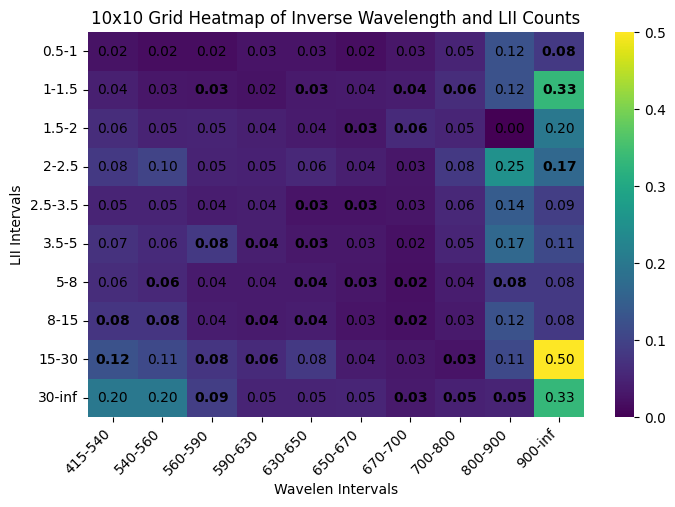

In [7]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import WeightedRandomSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Function to assign grid indices based on the ranges
def get_grid_index(value, ranges):
    for i, (low, high) in enumerate(ranges):
        if low < value <= high:
            return i
    return None

# Function to convert values to labels based on ranges
def labelConverter(Wavlength, LII):
    labels = []
    for w, l in zip(Wavlength, LII):
        w_index = get_grid_index(w, wavelen_ranges)
        l_index = get_grid_index(l, lii_ranges)
        if w_index is not None and l_index is not None:
            labels.append(l_index * 10 + w_index)
        else:
            labels.append(-1)  # Mark invalid samples with -1
    return np.array(labels)

# Read the CSV file
datafile = 'cleandata1.csv'  # Replace with your file path
df = pd.read_csv(datafile)

# Extract Wavelen and LII
wavelen = df['Wavelen']
lii = df['LII']

# Define the specified bin ranges for Wavelen and LII
wavelen_ranges = [(415, 540), (540, 560), (560, 590), (590, 630), (630, 650), (650, 670), (670, 700), (700, 800), (800, 900), (900, np.inf)]
lii_ranges = [(0.5, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, 3.5), (3.5, 5), (5, 8), (8, 15), (15, 30), (30, np.inf)]

# Create a 10x10 grid for counting occurrences
grid = np.zeros((10, 10))

# Fill the grid with counts
for w, l in zip(wavelen, lii):
    w_index = get_grid_index(w, wavelen_ranges)
    l_index = get_grid_index(l, lii_ranges)
    if w_index is not None and l_index is not None:
        grid[l_index, w_index] += 1

# Compute the inverse of the counts
inverse_grid = np.zeros_like(grid)
with np.errstate(divide='ignore'):  # Ignore division by zero warnings
    inverse_grid = np.where(grid != 0, 1.0 / grid, 0)

# Custom function to label the grid with top 32 values
def get_top_bins(sample_indices, wavelen, lii, wavelen_ranges, lii_ranges):
    bins = []
    unique_bins = set()
    for idx in sample_indices:
        w, l = wavelen[idx], lii[idx]
        w_index = get_grid_index(w, wavelen_ranges)
        l_index = get_grid_index(l, lii_ranges)
        if w_index is not None and l_index is not None:
            bin_coord = (l_index, w_index)
            if bin_coord not in unique_bins:
                unique_bins.add(bin_coord)
                bins.append(bin_coord)
                if len(bins) >= 32:
                    break
    return bins

# Function to return the top 32 sample indices
def dataSampler(Wavlength, LII):
    labels = labelConverter(Wavlength, LII)
    valid_labels = labels[labels >= 0]  # Filter out invalid labels
    class_sample_count = np.bincount(valid_labels, minlength=100)
    weights = 1. / torch.tensor(class_sample_count, dtype=torch.float)
    samples_weights = torch.zeros(len(labels))
    samples_weights[labels >= 0] = weights[valid_labels]

    sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=False)
    sample_indices = list(sampler)
    
    # Ensure 32 unique valid bins
    top_bins = get_top_bins(sample_indices, Wavlength, LII, wavelen_ranges, lii_ranges)
    
    return top_bins

# Get the top 32 bins
top_32_bins = dataSampler(wavelen, lii)

# Custom annotation function
def annotate_heatmap(ax, data, top_bins, **kwargs):
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = f"{data[i, j]:.2f}"
            if (i, j) in top_bins:
                text = f"$\\bf{{{text}}}$"  # Bold the top values
            ax.text(j + 0.5, i + 0.5, text,
                    ha='center', va='center', **kwargs)

# Create the heatmap
plt.figure(figsize=(8, 5))
ax = sns.heatmap(inverse_grid, annot=False, cmap="viridis", cbar=True)

# Annotate with custom function
annotate_heatmap(ax, inverse_grid, top_32_bins, color='k')

plt.title('10x10 Grid Heatmap of Inverse Wavelength and LII Counts')
plt.xlabel('Wavelen Intervals')
plt.ylabel('LII Intervals')

# Setting the ticks to show bin ranges
plt.xticks(ticks=np.arange(10) + 0.5, labels=[f'{low}-{high}' for low, high in wavelen_ranges], rotation=45, ha='right')
plt.yticks(ticks=np.arange(10) + 0.5, labels=[f'{low}-{high}' for low, high in lii_ranges], rotation=0)

plt.show()


In [8]:
df.describe()

,Wavelen,LII
count,2202.000000,2202.000000
mean,647.589289,9.856441
std,93.246959,24.819044
min,415.362329,0.503462
25%,581.029536,1.330673
50%,646.153320,3.034525
75%,681.356262,8.054088
max,1198.939516,408.481842


Value out of range: Wavelen=571.5428887, LII=0.503461861
Value out of range: Wavelen=415.3623286, LII=0.632684852


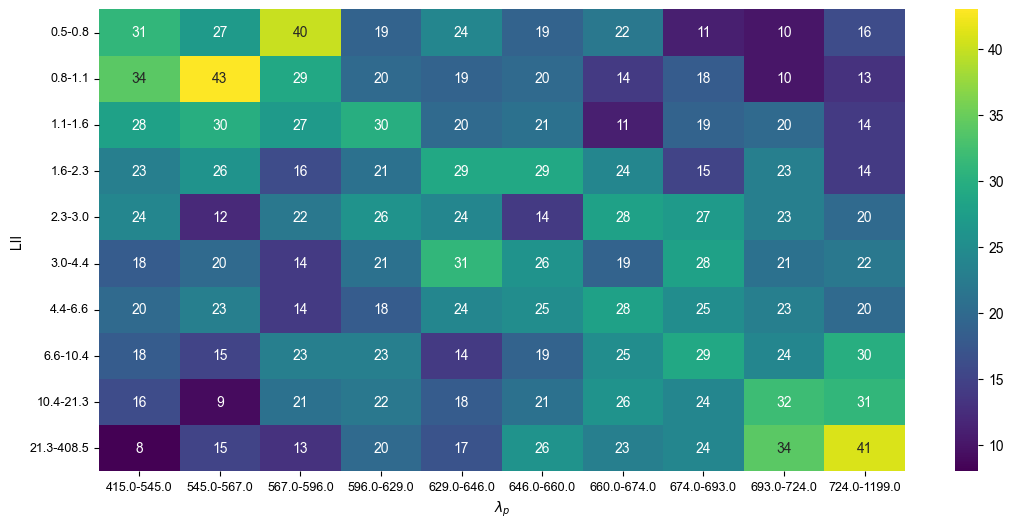

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Arial'

wavelen_ranges = [(415.3623286, 544.6402184), (544.6402184, 566.67668642), (566.67668642, 596.1659264900001), (596.1659264900001, 629.3332609400001), (629.3332609400001, 646.15331985), (646.15331985, 659.55252278), (659.55252278, 674.0124922699999), (674.0124922699999, 692.85871476), (692.85871476, 723.98894337), (723.98894337, 1198.939516)]



lii_ranges = [(0.503461861, 0.7904981883000001), (0.7904981883000001, 1.1061774474000001), (1.1061774474000001, 1.6431751672000001), (1.6431751672000001, 2.297711539600001), (2.297711539600001, 3.03452451), (3.03452451, 4.3811698676), (4.3811698676, 6.573917412), (6.573917412, 10.37579652600001), (10.37579652600001, 21.328033467), (21.328033467, 408.4818424)]


# Function to assign grid indices based on the ranges
def get_grid_index(wavelen, lii):
    wavelen_index = next((i for i, (low, high) in enumerate(wavelen_ranges) if low < wavelen <= high), None)
    lii_index = next((i for i, (low, high) in enumerate(lii_ranges) if low < lii <= high), None)
    return wavelen_index, lii_index

# Read the CSV file
datafile = 'cleandata1.csv'  # Replace with your file path
df = pd.read_csv(datafile)

# Create an empty 10x10 grid for counting occurrences
grid = np.zeros((10, 10))

# Iterate over the data and fill the grid
for _, row in df.iterrows():
    wavelen, lii = row['Wavelen'], row['LII']
    wavelen_index, lii_index = get_grid_index(wavelen, lii)
    if wavelen_index is not None and lii_index is not None:
        grid[lii_index, wavelen_index] += 1
    else:
        print(f"Value out of range: Wavelen={wavelen}, LII={lii}")

# Create a heatmap
plt.figure(figsize=(13, 6))
sns.heatmap(grid, annot=True, fmt=".0f", cmap="viridis")
#plt.title('data distribution in each bin')
plt.xlabel('$\lambda_p$')
plt.ylabel('LII')
plt.xticks(ticks=np.arange(10) + 0.5, labels=[f'{round(low, 0)}-{round(high, 0)}' for low, high in wavelen_ranges], rotation=0, ha='center', fontsize=9)
plt.yticks(ticks=np.arange(10) + 0.5, labels=[f'{round(low, 1)}-{round(high, 1)}' for low, high in lii_ranges], rotation=0, fontsize=9)
# plt.xticks(ticks=np.arange(10)+0.5, labels=np.arange(1, 11), rotation=0, ha='right')
# plt.yticks(ticks=np.arange(10)+0.5, labels=np.arange(1, 11), rotation=0)
plt.savefig('bins-count.pdf', format='pdf')
plt.show()


Value out of range: Wavelen=571.5428887, LII=0.503461861
Value out of range: Wavelen=415.3623286, LII=0.632684852


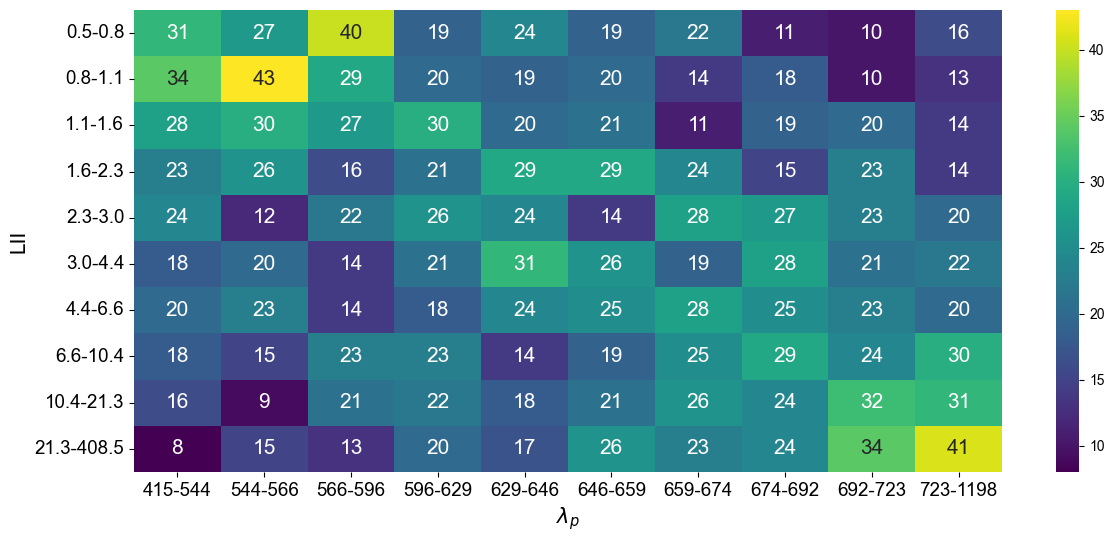

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Arial'

wavelen_ranges = [(415.3623286, 544.6402184), (544.6402184, 566.67668642), (566.67668642, 596.1659264900001), (596.1659264900001, 629.3332609400001), (629.3332609400001, 646.15331985), (646.15331985, 659.55252278), (659.55252278, 674.0124922699999), (674.0124922699999, 692.85871476), (692.85871476, 723.98894337), (723.98894337, 1198.939516)]

lii_ranges = [(0.503461861, 0.7904981883000001), (0.7904981883000001, 1.1061774474000001), (1.1061774474000001, 1.6431751672000001), (1.6431751672000001, 2.297711539600001), (2.297711539600001, 3.03452451), (3.03452451, 4.3811698676), (4.3811698676, 6.573917412), (6.573917412, 10.37579652600001), (10.37579652600001, 21.328033467), (21.328033467, 408.4818424)]

# Function to assign grid indices based on the ranges
def get_grid_index(wavelen, lii):
    wavelen_index = next((i for i, (low, high) in enumerate(wavelen_ranges) if low < wavelen <= high), None)
    lii_index = next((i for i, (low, high) in enumerate(lii_ranges) if low < lii <= high), None)
    return wavelen_index, lii_index

# Read the CSV file
datafile = 'cleandata1.csv'  # Replace with your file path
df = pd.read_csv(datafile)

# Create an empty 10x10 grid for counting occurrences
grid = np.zeros((10, 10))

# Iterate over the data and fill the grid
for _, row in df.iterrows():
    wavelen, lii = row['Wavelen'], row['LII']
    wavelen_index, lii_index = get_grid_index(wavelen, lii)
    if wavelen_index is not None and lii_index is not None:
        grid[lii_index, wavelen_index] += 1
    else:
        print(f"Value out of range: Wavelen={wavelen}, LII={lii}")

# Create a heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(grid, annot=True, fmt=".0f", cmap="viridis", annot_kws={"size": 15})  # Adjust the size of the numbers in the cells
plt.xlabel('$\lambda_p$', fontsize=15)
plt.ylabel('LII', fontsize=15)
plt.xticks(ticks=np.arange(10) + 0.5, labels=[f'{int(low)}-{int(high)}' for low, high in wavelen_ranges], rotation=0, ha='center', fontsize=13.5)
plt.yticks(ticks=np.arange(10) + 0.5, labels=[f'{round(low, 1)}-{round(high, 1)}' for low, high in lii_ranges], rotation=0, fontsize=13.5)
plt.savefig('bins-count.pdf', format='pdf')
plt.show()


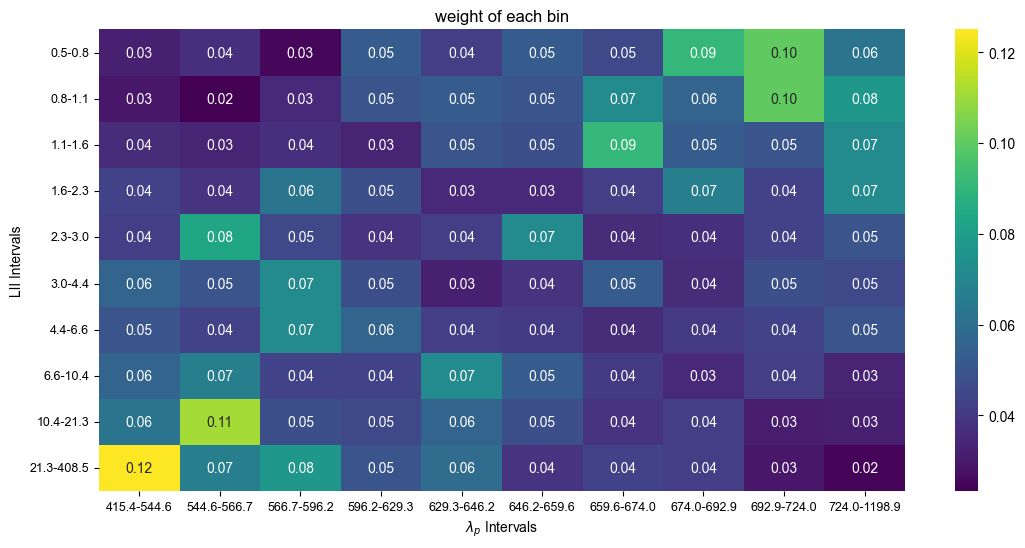

In [3]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Arial'

# Read the CSV file
datafile = 'cleandata1.csv'  # Replace with your file path
df = pd.read_csv(datafile)

# Extract Wavelen and LII
wavelen = df['Wavelen']
lii = df['LII']

# Define the specified bin ranges for Wavelen and LII
wavelen_ranges = [(415.3623286, 544.6402184), (544.6402184, 566.67668642), (566.67668642, 596.1659264900001), (596.1659264900001, 629.3332609400001), (629.3332609400001, 646.15331985), (646.15331985, 659.55252278), (659.55252278, 674.0124922699999), (674.0124922699999, 692.85871476), (692.85871476, 723.98894337), (723.98894337, 1198.939516)]



lii_ranges = [(0.503461861, 0.7904981883000001), (0.7904981883000001, 1.1061774474000001), (1.1061774474000001, 1.6431751672000001), (1.6431751672000001, 2.297711539600001), (2.297711539600001, 3.03452451), (3.03452451, 4.3811698676), (4.3811698676, 6.573917412), (6.573917412, 10.37579652600001), (10.37579652600001, 21.328033467), (21.328033467, 408.4818424)]


# Function to assign grid indices based on the ranges
def get_grid_index(value, ranges):
    for i, (low, high) in enumerate(ranges):
        if low < value <= high:
            return i
    return None

# Create a 10x10 grid for counting occurrences
grid = np.zeros((10, 10))

# Fill the grid with counts
for w, l in zip(wavelen, lii):
    w_index = get_grid_index(w, wavelen_ranges)
    l_index = get_grid_index(l, lii_ranges)
    if w_index is not None and l_index is not None:
        grid[l_index, w_index] += 1

# Compute the inverse of the counts
inverse_grid = np.zeros_like(grid)
with np.errstate(divide='ignore'):  # Ignore division by zero warnings
    inverse_grid = np.where(grid != 0, 1.0 / grid, 0)

# Create the heatmap
plt.figure(figsize=(13, 6))
sns.heatmap(inverse_grid, annot=True, fmt=".2f", cmap="viridis")
plt.title('weight of each bin')
plt.xlabel('$\lambda_p$ Intervals')
plt.ylabel('LII Intervals')

# Setting the ticks to show bin ranges
plt.xticks(ticks=np.arange(10) + 0.5, labels=[f'{round(low, 1)}-{round(high, 1)}' for low, high in wavelen_ranges], rotation=0, ha='center', fontsize=9)
plt.yticks(ticks=np.arange(10) + 0.5, labels=[f'{round(low, 1)}-{round(high, 1)}' for low, high in lii_ranges], rotation=0, fontsize=9)
plt.savefig('bins-weight.pdf', format='pdf')
plt.show()


In [12]:
import pandas as pd
import numpy as np

# Load the data
file_path = 'cleandata1.csv'  # Update the file path if necessary
df = pd.read_csv(file_path)

# Number of bins
num_bins = 10

# Create quantile-based bins for 'wavelen' and 'LII'
df['Wavelen_bin'] = pd.qcut(df['Wavelen'], num_bins, labels=False, duplicates='drop')
df['lii_bin'] = pd.qcut(df['LII'], num_bins, labels=False, duplicates='drop')

# Create a 10x10 grid to count the number of samples in each bin
grid = np.zeros((num_bins, num_bins))

for i in range(num_bins):
    for j in range(num_bins):
        count = df[(df['Wavelen_bin'] == i) & (df['lii_bin'] == j)].shape[0]
        grid[i, j] = count

# Display the grid
print("10x10 Grid showing the number of samples in each bin:")
print(grid)

# Optional: Convert grid to DataFrame for better readability
grid_df = pd.DataFrame(grid, index=[f'wavelen_bin_{i}' for i in range(num_bins)], columns=[f'lii_bin_{j}' for j in range(num_bins)])
print(grid_df)


10x10 Grid showing the number of samples in each bin:
[[32. 34. 28. 23. 24. 18. 20. 18. 16.  8.]
 [27. 43. 30. 26. 12. 20. 23. 15.  9. 15.]
 [41. 29. 27. 16. 22. 14. 14. 23. 21. 13.]
 [19. 20. 30. 21. 26. 21. 18. 23. 22. 20.]
 [24. 19. 20. 29. 24. 31. 24. 14. 18. 17.]
 [19. 20. 21. 29. 14. 26. 25. 19. 21. 26.]
 [22. 14. 11. 24. 28. 19. 28. 25. 26. 23.]
 [11. 18. 19. 15. 27. 28. 25. 29. 24. 24.]
 [10. 10. 20. 23. 23. 21. 23. 24. 32. 34.]
 [16. 13. 14. 14. 20. 22. 20. 30. 31. 41.]]
               lii_bin_0  lii_bin_1  lii_bin_2  lii_bin_3  lii_bin_4  \
wavelen_bin_0       32.0       34.0       28.0       23.0       24.0   
wavelen_bin_1       27.0       43.0       30.0       26.0       12.0   
wavelen_bin_2       41.0       29.0       27.0       16.0       22.0   
wavelen_bin_3       19.0       20.0       30.0       21.0       26.0   
wavelen_bin_4       24.0       19.0       20.0       29.0       24.0   
wavelen_bin_5       19.0       20.0       21.0       29.0       14.0   
wavelen_bin

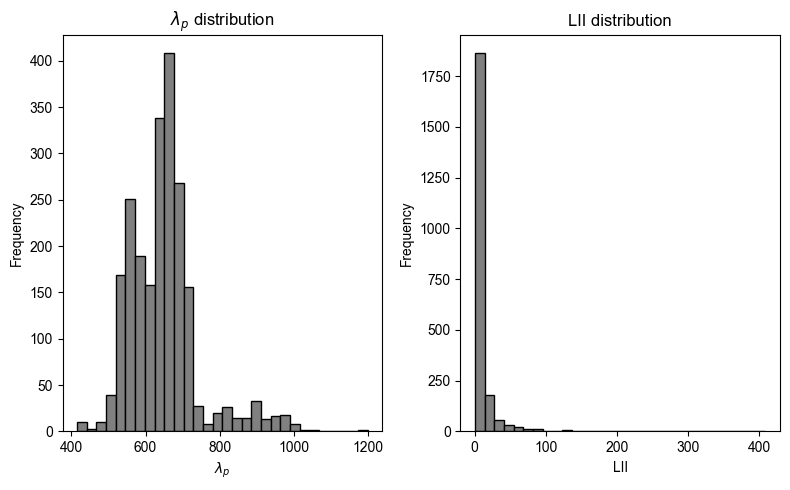

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Set the font to Arial
plt.rcParams['font.family'] = 'Arial'

# Read the CSV file
datafile = 'cleandata1.csv'  # Replace with your file path
df = pd.read_csv(datafile)

# Create a histogram for the 'Wavelen' column
plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
plt.hist(df['Wavelen'], bins=30, color='gray', edgecolor='black')
plt.title('$\lambda_p$ distribution')
plt.xlabel('$\lambda_p$')
plt.ylabel('Frequency')

# Create a histogram for the 'LII' column
plt.subplot(1, 2, 2)
plt.hist(df['LII'], bins=30, color='gray', edgecolor='black')
plt.title('LII distribution')
plt.xlabel('LII')
plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure to a PDF file
plt.savefig('histograms.pdf', format='pdf')

# Show the plot
plt.show()
